# Classify the Disease

This challenge is part of bigger challenge concerned with classifying Cassava leaves diseases. The description from Kaggle website:<br>
In this competition, we introduce a dataset of 5 fine-grained cassava leaf disease categories with 9,436 labeled images collected during a regular survey in Uganda, mostly crowdsourced from farmers taking images of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab in Makarere University, Kampala. 

In [0]:
# it takes toooooo long
!rm -r '/content/train'
shutil.copytree("/content/gdrive/My Drive/Colab Notebooks/data/cassava_psuedo", "/content/train/")

'/content/train/'

In [0]:
!pip3 install comet_ml

In [0]:
# Import comet_ml in the top of your file
from comet_ml import Experiment

# Create an experiment
experiment = Experiment(api_key="0sCfIWNDDrmo1BtCDHNA0BPXd",
                        project_name="general", workspace="sara-ebrahim")



from fastai.vision import *
import fastai
from PIL import Image
import shutil

import numpy as np
import matplotlib.pyplot as plot
import pandas as pd

import torch
# import fastai
# from fastai import vision

!pip install pretrainedmodels
import pretrainedmodels as pm
%matplotlib inline

torch.cuda.is_available(), torch.backends.cudnn.enabled

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sara-ebrahim/general/b93298553da04c81a26180ae87bd85c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy                      : (0.5773651599884033, 0.5773651599884033)
COMET INFO:     curr_epoch                    : 0
COMET INFO:     loss [13]                     : (1.2195637226104736, 2.444833755493164)
COMET INFO:     sys.gpu.0.free_memory [51]    : (457113600.0, 15812263936.0)
COMET INFO:     sys.gpu.0.gpu_utilization [51]: (0.0, 77.0)
COMET INFO:     sys.gpu.0.total_memory        : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory [51]    : (0.0, 15355150336.0)
COMET INFO:     val_loss                      : (1.1856286525726318, 1.1856286525726318)
COMET INFO:   Other [count]:
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sara-ebrahim/general/b3aa

(True, True)

In [0]:
experiment.end()

In [0]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

## Get the Data from Kaggle

In [0]:
# Colab's file access feature
from google.colab import drive
drive.mount('/content/gdrive')
json_file = '/content/gdrive/My Drive/Colab Notebooks/data/kaggle.json'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp '/content/gdrive/My Drive/Colab Notebooks/data/kaggle.json' ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [0]:
#download data, will take 30-60 seconds
!kaggle competitions download -c cassava-disease

sample_submission_file.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
extraimages.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzip all data for usage, will take few minutes
!unzip -qq train.zip
!unzip -qq extraimages.zip
!unzip -qq test.zip

## Load the Data in Fastai and Exploring it

I am going to use [this dataset](https://www.kaggle.com/c/cassava-disease/data) which has 5 categories of cassava leaves diseases. Fastai model will need to learn to differentiate between these 5 different categories. 


In [0]:
transform_kwargs = {"do_flip": True,
                    "flip_vert": True,
                    "max_rotate": 180,
                    "max_zoom": 1.1,
                    "max_lighting": 0.2,
                    "max_warp": 0.2,
                    "p_affine": 0.75,
                    "p_lighting": 0.7,
                    "xtra_tfms" : zoom_crop(scale=(0.5, 1.5), do_rand=True)}
        
tfms = vision.get_transforms(**transform_kwargs)

# data_bunch_kwargs = {"path": "/content/train",
#                      "train": "train",
#                      "valid_pct": 0.1,
#                      "size": 224,
#                      "bs": 64,
#                      "ds_tfms": tfms,
#                      "test": "/content/test/0"}
# data = (vision.ImageDataBunch
#                           .from_folder(**data_bunch_kwargs)
#                           .normalize())


data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/test/0')
        .databunch(bs = 64))    

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [0]:
data.show_batch(rows=5, figsize=(20,20))

## Training: use pretrained architecture

In [0]:
model_name = 'se_resnext101' # 'vgg_16_2'

_base_arch = lambda arg: pm.se_resnext101_32x4d(num_classes=5, pretrained=None)
learner = vision.cnn_learner(data, 
                             base_arch = _base_arch, 
                             pretrained = False, 
                             metrics = vision.accuracy)

# Report any information you need by:
# hyper_params = {"learning_rate": 0.5, "steps": 100000, "batch_size": 50}
# experiment.log_parameters(hyper_params)

batch_size = 64
arch_name = 'resnetxt101_32x46'
experiment.log_parameter("batch size", batch_size)
experiment.log_parameter("architecture", arch_name)



# model_name = 'vgg_16_2'
# used_model = models.vgg16_bn #lambda arg: pm.se_resnext101_32x4d(num_classes=5, pretrained=None)
# # other models: PNASNet-5-Large, NASNet-A-Large, SENet154, ResNet152, ResNet101, Densenet121
# learner = cnn_learner(data, base_arch = used_model, 
#                       pretrained = True, metrics = accuracy)
# #                       model_dir="/content/models/se-resnext101-32x4d").mixup()

# best model so far .. model_name = vgg_16_2
# learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-7')
# learner.data = data


Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier and output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learner.fit_one_cycle(3)
# learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-1')
# train_accuracy = "some value"
# experiment.log_metric("acc", train_accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,1.567251,1.195093,0.577365,02:40
1,1.378452,1.165235,0.580902,02:39
2,1.276385,1.082195,0.605659,02:39


Load or save model (depends on the experiment type and the internet connection :D)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

In [0]:
# interp = ClassificationInterpretation.from_learner(learn)

# losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
# interp.plot_top_losses(20, figsize=(20,20))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=100)

## Unfreezing, fine-tuning, and slicing learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
# learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-1')


In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-1')

learner.unfreeze()
learner.fit_one_cycle(3)

learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.883884,1.031066,0.604775,02:38
1,0.931285,1.481517,0.375774,02:37
2,0.868880,0.727773,0.729443,02:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


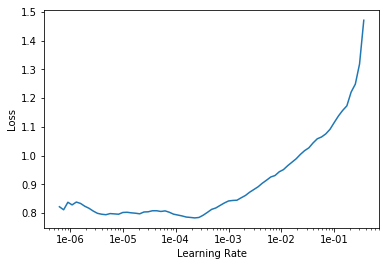

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-2');
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-2');
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.816649,0.721470,0.732980,02:36
1,0.809501,0.717219,0.729443,02:38


COMET ERROR: Failed to run CallbackHander.on_epoch_end logger
COMET ERROR: Failed to run CallbackHander.on_epoch_end logger


In [0]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sara-ebrahim/general/b3aa23e9b6c846d99a79da28d0e500cc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [11]                 : (0.3757736384868622, 0.7294429540634155)
COMET INFO:     curr_epoch [10]               : 1
COMET INFO:     loss [129]                    : (0.679923415184021, 2.444833755493164)
COMET INFO:     sys.gpu.0.free_memory [75]    : (67043328.0, 14000521216.0)
COMET INFO:     sys.gpu.0.gpu_utilization [75]: (0.0, 99.0)
COMET INFO:     sys.gpu.0.total_memory        : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory [75]    : (1811742720.0, 15745220608.0)
COMET INFO:     val_loss [15]                 : None
COMET INFO:   Other [count]:
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


That's a pretty accurate model!

## Progressive Resizing: training with bigger image sizes


Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=256)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs = 32))                   #Finally? -> use the defaults for conversion to ImageDataBunch

learner.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


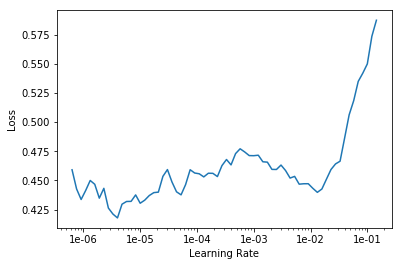

In [0]:
learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [0]:
lr = 1e-05/2
learner.fit_one_cycle(15, lr)
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-4')

epoch,train_loss,valid_loss,accuracy,time
0,0.454448,116.619850,0.868258,02:07
1,0.456796,96.297997,0.870027,02:07
2,0.450283,76.334442,0.881521,02:08
3,0.461843,65.412125,0.877984,02:08
4,0.454164,29.269217,0.886826,02:08
5,0.488226,33.827579,0.888594,02:08
6,0.464505,57.376148,0.881521,02:08
7,0.467506,34.742767,0.886826,02:08
8,0.456649,71.337654,0.878868,02:08
9,0.468848,7.156239,0.888594,02:08


It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-4');
learner.unfreeze()
learner.fit_one_cycle(15, max_lr=slice(1e-6,1e-4))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-5')

epoch,train_loss,valid_loss,accuracy,time
0,0.459266,42.874939,0.887710,03:00
1,0.458194,53.438152,0.885942,02:58
2,0.457229,119.333015,0.875332,02:58
3,0.438418,85.797821,0.877984,02:58
4,0.455834,63.514065,0.870911,02:58
5,0.463041,43.266850,0.880637,02:59
6,0.470214,34.603477,0.877984,02:58
7,0.449719,61.718330,0.875332,02:58
8,0.459925,47.701454,0.883289,02:58
9,0.449155,33.992973,0.875332,02:58


In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-5')
learner.fit_one_cycle(10 , max_lr=slice(1e-6,1e-4))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-6')

epoch,train_loss,valid_loss,accuracy,time
0,0.473044,59.391197,0.873563,02:59
1,0.448179,38.743610,0.884173,02:58
2,0.442984,31.345922,0.879752,02:58
3,0.454700,29.951311,0.879752,02:58
4,0.448326,34.256927,0.879752,02:58
5,0.461629,158.594818,0.860301,02:58
6,0.444093,31.355349,0.880637,02:58
7,0.440942,63.751568,0.875332,02:58
8,0.439963,49.842224,0.874447,02:58
9,0.482963,23.343031,0.884173,02:58


### Even bigger: size 512

In [0]:

data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=512)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/test/0')
        .databunch(bs = 8))                   #Finally? -> use the defaults for conversion to ImageDataBunch

learner.data = data

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-6')
learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-6')
lr = 1e-04/2
learner.fit_one_cycle(15, lr)
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-7')

RuntimeError: ignored

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-7')
learner.unfreeze()
learner.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-8')

In [0]:
learner.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_stage-9')

## Using the extraimages: psuedo-labeling

### Use our pretrained model to predict the labels for our extra images¶


In [0]:
data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=512)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/extraimages/')
        .databunch(bs = 16))                   #Finally? -> use the defaults for conversion to ImageDataBunch

learner.data = data

# Generate the psuedo labels with the best loaded model
predicted_probs_extra, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
predicted_class_probs, predicted_classes_extra = predicted_probs_extra.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes_extra]


### Creating the new training dataset (original + extraimages with pseudo labels)

In [0]:
threshold = 0.95  # only include pseudo-labeled images where model is sufficiently confident in its prediction
filenames = [item.name for item in learner.data.test_ds.items]
for predicted_class_label, predicted_class_probability, filename in zip(predicted_class_labels, predicted_class_probs, filenames):
#     print(predicted_class_label, predicted_class_probability)
    if predicted_class_probability > threshold:
        shutil.copy(f"/content/extraimages/{filename}", f"/content/train/{predicted_class_label}/{filename}")

In [0]:
# save the whole trained images on the drive
shutil.copytree("/content/train/", "/content/gdrive/My Drive/Colab Notebooks/data/cassava_psuedo")

## Train the model on the new training dataset

In [0]:
data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/test/0')
        .databunch(bs = 64))   

learner = cnn_learner(data, base_arch = used_model, 
                      pretrained = True, metrics = accuracy).mixup()


learner.fit_one_cycle(15)
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.466045,0.839574,0.717036,03:40
1,1.090337,0.582101,0.809218,03:37
2,0.944234,0.530907,0.827305,03:35
3,0.870965,0.502162,0.836056,03:37
4,0.820690,0.493417,0.844807,03:35
5,0.791908,0.443690,0.851809,03:34
6,0.767706,0.402851,0.865228,03:38
7,0.758238,0.390903,0.880980,03:41
8,0.752724,0.394898,0.872812,03:40
9,0.731240,0.376410,0.882730,03:40


NameError: ignored

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-1')
learner.unfreeze()
learner.fit_one_cycle(15)
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-2')

learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-2');
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.676135,0.322824,0.901984,03:49
1,0.661584,0.344665,0.890898,03:51
2,0.652516,0.327513,0.903150,03:50
3,0.672744,0.331228,0.898483,03:49
4,0.669415,0.340415,0.895566,03:48
5,0.647628,0.294214,0.918320,03:50
6,0.635406,0.432492,0.861727,03:47
7,0.626363,0.298625,0.909568,03:48
8,0.596764,0.273430,0.926488,03:51
9,0.598253,0.263412,0.929988,03:50


epoch,train_loss,valid_loss,accuracy,time
0,0.533425,0.220302,0.936406,03:50
1,0.532241,0.229723,0.930572,03:49
2,0.529662,0.219360,0.935239,03:50
3,0.530167,0.219651,0.936989,03:50
4,0.521683,0.213083,0.936989,03:50


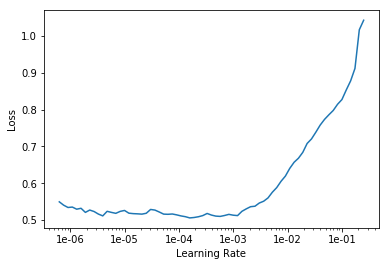

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
data = (ImageList.from_folder('/content/train') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=256)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/test/0')
        .databunch(bs = 32))                   #Finally? -> use the defaults for conversion to ImageDataBunch

learner.data = data

lr = 1e-04/2
learner.fit_one_cycle(6, lr)
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-4')

epoch,train_loss,valid_loss,accuracy,time
0,0.631753,0.263524,0.928238,02:54
1,0.590399,0.234707,0.935239,02:56
2,0.586690,0.232578,0.939323,02:55
3,0.543237,0.225696,0.936406,02:55
4,0.543768,0.216613,0.936406,02:54
5,0.542041,0.216063,0.939323,02:55


In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-4');
learner.unfreeze()
learner.fit_one_cycle(8, max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-5')

learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-5')
learner.fit_one_cycle(5 , max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-6')

epoch,train_loss,valid_loss,accuracy,time
0,0.556783,0.212150,0.938740,02:54
1,0.560703,0.215944,0.935823,02:55
2,0.550800,0.210255,0.939907,02:55
3,0.554385,0.216101,0.935823,02:54
4,0.557841,0.219165,0.932905,02:55
5,0.523029,0.204526,0.942240,02:55
6,0.538608,0.202938,0.940490,02:54
7,0.538844,0.203112,0.939323,02:55


epoch,train_loss,valid_loss,accuracy,time
0,0.528350,0.211372,0.938156,02:54
1,0.544696,0.210728,0.942824,02:55
2,0.532509,0.207188,0.939907,02:54
3,0.515235,0.207524,0.939323,02:56
4,0.504804,0.210891,0.937573,02:56


In [0]:
data = (ImageList.from_folder("/content/gdrive/My Drive/Colab Notebooks/data/cassava_psuedo") #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=512)       #Data augmentation? -> use tfms with a size of 64
        .add_test_folder('/content/test/0')
        .databunch(bs = 16))                   #Finally? -> use the defaults for conversion to ImageDataBunch

learner.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


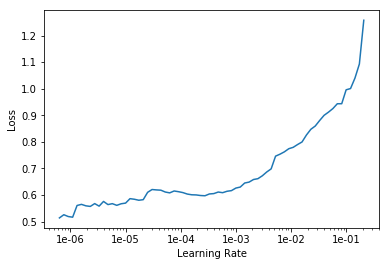

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
# learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-6')
# lr = 1e-04/2
# learner.fit_one_cycle(10, lr)
# learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-7')

# learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-7')
# learner.unfreeze()
# learner.fit_one_cycle(4, max_l_pseudo_start_pseudo_startr=slice(1e-5,1e-3))
# learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-8')

learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-8')
learner.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))
learner.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-9')

NameError: ignored

## Submit predictions

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-7')
learner.export()

predicted_probs, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
# predicted_probs, y = learner.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in data.test_ds.items])
submission = (pd.DataFrame.from_dict({'Category': predicted_class_labels,'Id': filenames}))
sub_file = '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_7.csv'
submission.to_csv(sub_file, header=True, index=False)

!kaggle competitions submit cassava-disease -f '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_7.csv' -m '12th submission'

100% 81.8k/81.8k [00:03<00:00, 27.2kB/s]
Successfully submitted to Cassava Disease Classification 

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-8')
learner.export()

predicted_probs, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
# predicted_probs, y = learner.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in data.test_ds.items])
submission = (pd.DataFrame.from_dict({'Category': predicted_class_labels,'Id': filenames}))
sub_file = '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_8.csv'
submission.to_csv(sub_file, header=True, index=False)

!kaggle competitions submit cassava-disease -f '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_8.csv' -m '12th submission'

100% 81.7k/81.7k [00:03<00:00, 23.4kB/s]
Successfully submitted to Cassava Disease Classification 

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_pseudo_start-9')
learner.export()

predicted_probs, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
# predicted_probs, y = learner.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in data.test_ds.items])
submission = (pd.DataFrame.from_dict({'Category': predicted_class_labels,'Id': filenames}))
sub_file = '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_9.csv'
submission.to_csv(sub_file, header=True, index=False)

!kaggle competitions submit cassava-disease -f '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_start_9.csv' -m '12th submission'

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_psuedo-10')
learner.export()

predicted_probs, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
# predicted_probs, y = learner.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in data.test_ds.items])
submission = (pd.DataFrame.from_dict({'Category': predicted_class_labels,'Id': filenames}))
sub_file = '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_10.csv'
submission.to_csv(sub_file, header=True, index=False)

!kaggle competitions submit cassava-disease -f '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_10.csv' -m '12th submission'

100% 81.8k/81.8k [00:02<00:00, 40.5kB/s]
Successfully submitted to Cassava Disease Classification 

In [0]:
learner.load('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_'+model_name+'_psuedo-11')
learner.export()

predicted_probs, _ = learner.TTA(ds_type = fastai.basic_data.DatasetType.Test)
# predicted_probs, y = learner.get_preds(ds_type = fastai.basic_data.DatasetType.Test)

_, predicted_classes = predicted_probs.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[predicted_classes]

filenames = np.array([item.name for item in data.test_ds.items])
submission = (pd.DataFrame.from_dict({'Category': predicted_class_labels,'Id': filenames}))
sub_file = '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_11.csv'
submission.to_csv(sub_file, header=True, index=False)

!kaggle competitions submit cassava-disease -f '/content/gdrive/My Drive/Colab Notebooks/Kaggle/cassava_challenge/late_submission_pseudo_11.csv' -m '12th submission'

100% 81.8k/81.8k [00:02<00:00, 38.6kB/s]
Successfully submitted to Cassava Disease Classification 

## Results

**vgg_16_2**: (with 512 resizing)
* stage_1: 0.812 (needed more than 10 epochs)
* stage_2: 0.887 (needed more than 10 epochs)  
* stage_3:  0.895 (needed more than 15 epochs)
* stage_4:  0.928 (needed more than 5 epochs)    Kaggle: 0.87483
* stage_5:  0.923 (needed more than 5 epochs) 
* stage_6:  0.924 (needed more than 8 epochs) 

* train, unfreeze, resize twice: stage_7: 0.923
* TTA 8: 0.93021

## Use the unlabelled data: Use UNet Architecture (Super Resolution)

In [0]:
%cd /content
!mkdir all_img
%cd all_img
!mkdir train
!mkdir crappy #if using superres

/content
/content/all_img


In [0]:
!mv  /content/extraimages/* /content/all_img/train/

In [0]:
path_hr = pathlib.PosixPath('/content/all_img/train')
path_lr = pathlib.PosixPath('/content/all_img/crappy')

In [0]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(80,90)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest)#, quality=q)#######

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappify, il.items)

### Pretrained Generator

In [0]:
# We can apply gradual resizing later

bs,size = 32, 128 
# bs,size = 24,160
# bs,size = 8,256
# arch = learn.model

arch = models.resnet34
src = ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
src.train

ImageImageList (11336 items)
Image (3, 666, 500),Image (3, 666, 500),Image (3, 666, 500),Image (3, 666, 500),Image (3, 666, 500)
Path: /content/all_img/train

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

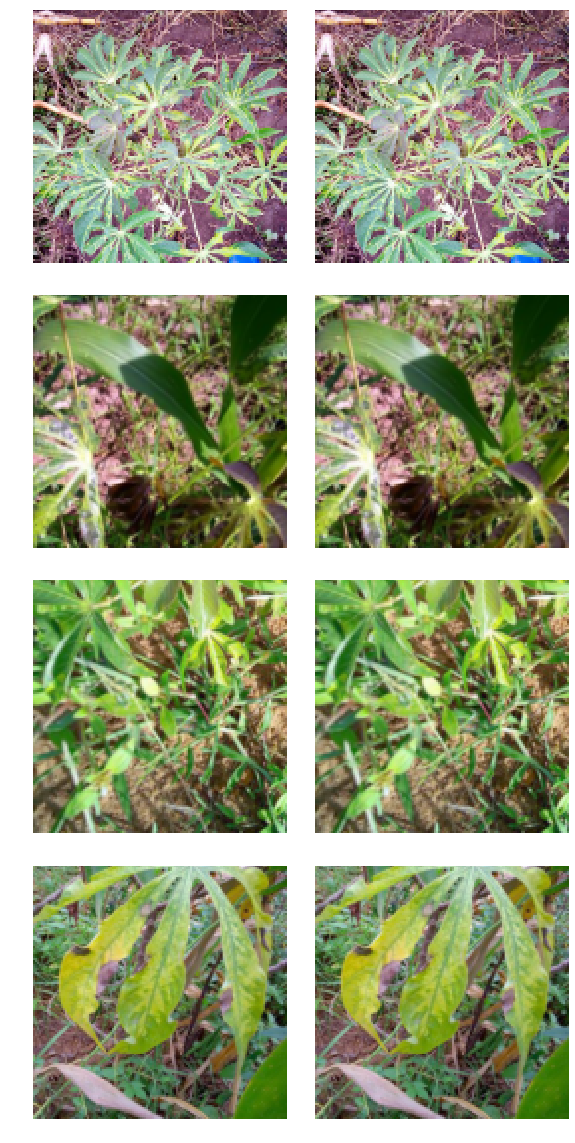

In [0]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 29645043.02it/s]


In [0]:
# learn_gen.model[0] = learn.model[0] #try another way

In [0]:
learn_gen.fit_one_cycle(5, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.005547,0.005104,06:09
1,0.002501,0.001748,05:59
2,0.001517,0.000988,05:56
3,0.000927,0.000749,05:56
4,0.000137,0.000166,05:55


In [0]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.000096,0.000119,05:57


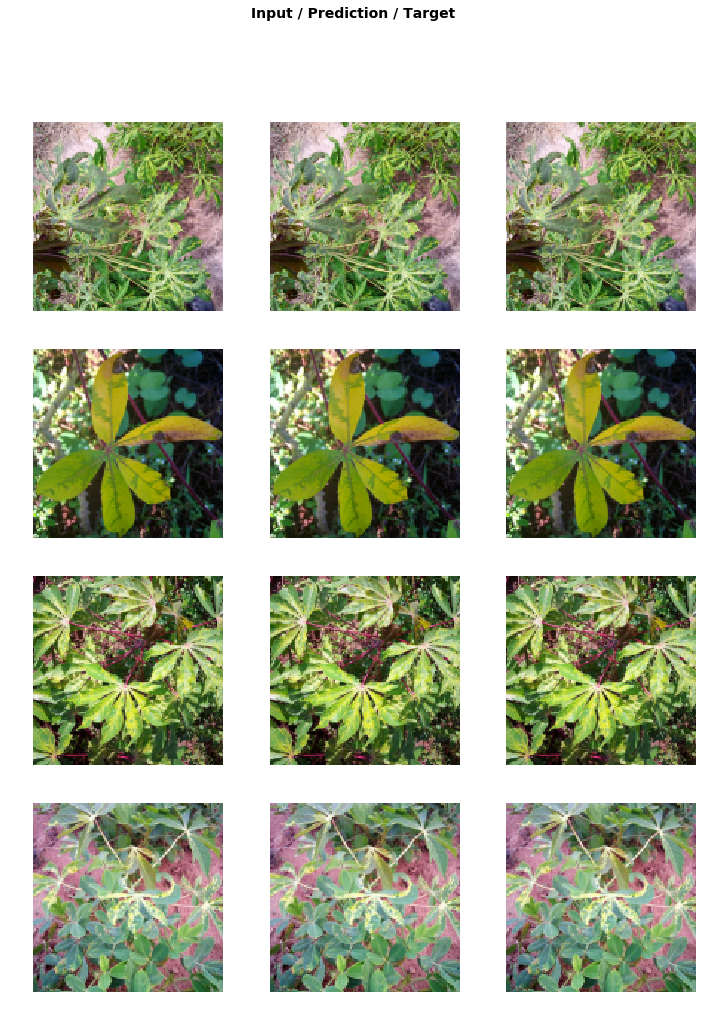

In [0]:
learn_gen.show_results(rows=4)

In [0]:
# save the unet learner
learn_gen.save('/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_superres_unet_full')

In [0]:
# save the downsampling part only
torch.save(learn_gen.model[0], '/content/gdrive/My Drive/Colab Notebooks/models/cassava_fastai_gen_only_full')